In [314]:
import math
import numpy as np
import pandas as pd
from datetime import datetime
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


In [315]:
consumption_df = pd.read_csv('household_power_consumption.txt', sep=';')

Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.

https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption

This dataset is licensed under a Creative Commons Attribution 4.0 International (CC BY 4.0) license.

In [274]:
consumption_df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [275]:
consumption_df['Datetime'] = pd.to_datetime(consumption_df['Date'] + ' ' + consumption_df['Time'])

# You might want to drop the original Date and Time columns if they are no longer needed
consumption_df = consumption_df.drop(columns=['Date', 'Time'])

consumption_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0,2006-12-16 17:24:00
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0,2006-12-16 17:25:00
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0,2006-12-16 17:26:00
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0,2006-12-16 17:27:00
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0,2006-12-16 17:28:00


In [276]:
consumption_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Global_active_power    object        
 1   Global_reactive_power  object        
 2   Voltage                object        
 3   Global_intensity       object        
 4   Sub_metering_1         object        
 5   Sub_metering_2         object        
 6   Sub_metering_3         float64       
 7   Datetime               datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 126.7+ MB


In [277]:
for col in consumption_df.columns:
    if consumption_df[col].dtype == 'object':
        consumption_df[col] = pd.to_numeric(consumption_df[col], errors='coerce')

In [278]:
consumption_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Global_active_power    float64       
 1   Global_reactive_power  float64       
 2   Voltage                float64       
 3   Global_intensity       float64       
 4   Sub_metering_1         float64       
 5   Sub_metering_2         float64       
 6   Sub_metering_3         float64       
 7   Datetime               datetime64[ns]
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


In [279]:
consumption_df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
Datetime                     0
dtype: int64

In [280]:
missing_data_rows = consumption_df[consumption_df['Global_active_power'].isnull()]

print(missing_data_rows.head())


       Global_active_power  Global_reactive_power  Voltage  Global_intensity  \
6839                   NaN                    NaN      NaN               NaN   
6840                   NaN                    NaN      NaN               NaN   
19724                  NaN                    NaN      NaN               NaN   
19725                  NaN                    NaN      NaN               NaN   
41832                  NaN                    NaN      NaN               NaN   

       Sub_metering_1  Sub_metering_2  Sub_metering_3            Datetime  
6839              NaN             NaN             NaN 2006-12-21 11:23:00  
6840              NaN             NaN             NaN 2006-12-21 11:24:00  
19724             NaN             NaN             NaN 2006-12-30 10:08:00  
19725             NaN             NaN             NaN 2006-12-30 10:09:00  
41832             NaN             NaN             NaN 2007-01-14 18:36:00  


I will be interploating the missing values as for the time-series analysis is crucial to keep the sequence of the data - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html

In [281]:
df_simplified = consumption_df[['Datetime', 'Global_active_power']].copy()

df_simplified.set_index('Datetime', inplace=True)

# Handle missing values. Here, we'll use forward fill as an example
df_simplified['Global_active_power'].fillna(method='ffill', inplace=True)

df_simplified.head()

,Global_active_power
Datetime,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666


In [282]:
print(df_simplified.index)

DatetimeIndex(['2006-12-16 17:24:00', '2006-12-16 17:25:00',
               '2006-12-16 17:26:00', '2006-12-16 17:27:00',
               '2006-12-16 17:28:00', '2006-12-16 17:29:00',
               '2006-12-16 17:30:00', '2006-12-16 17:31:00',
               '2006-12-16 17:32:00', '2006-12-16 17:33:00',
               ...
               '2010-11-26 20:53:00', '2010-11-26 20:54:00',
               '2010-11-26 20:55:00', '2010-11-26 20:56:00',
               '2010-11-26 20:57:00', '2010-11-26 20:58:00',
               '2010-11-26 20:59:00', '2010-11-26 21:00:00',
               '2010-11-26 21:01:00', '2010-11-26 21:02:00'],
              dtype='datetime64[ns]', name='Datetime', length=2075259, freq=None)


In [283]:
df_simplified.isnull().sum()

Global_active_power    0
dtype: int64

As the dataset has entry values for each minute, I will aggregate this on an hourly level (taking the mean value) as I am intrested in the hourly consumption. 

In [290]:
# Assuming your DataFrame is named df and 'Datetime' is already set as the datetime index
# If 'Datetime' is not the index, you would first do:
# df_simplified['Datetime'] = df_simplified.to_datetime(df['Datetime'])
# df_simplified.set_index('Datetime', inplace=True)

# Resample to hourly data and compute the mean
hourly_df = df_simplified.resample('H').mean()

# Let's check the first few rows of the aggregated hourly data
hourly_df.head()


,Global_active_power
Datetime,
2006-12-16 17:00:00,4.222889
2006-12-16 18:00:00,3.632200
2006-12-16 19:00:00,3.400233
2006-12-16 20:00:00,3.268567
2006-12-16 21:00:00,3.056467


In [291]:
hourly_df['Global_active_power'].fillna(method='ffill', inplace=True)

In [292]:
hourly_df.isnull().sum()

Global_active_power    0
dtype: int64

(array([323969, 324336, 333096, 341880, 350640, 358919], dtype=int64),
 [Text(323969, 0, ''),
  Text(324336, 0, 'Jan\n2007'),
  Text(333096, 0, 'Jan\n2008'),
  Text(341880, 0, 'Jan\n2009'),
  Text(350640, 0, 'Jan\n2010'),
  Text(358919, 0, '')])

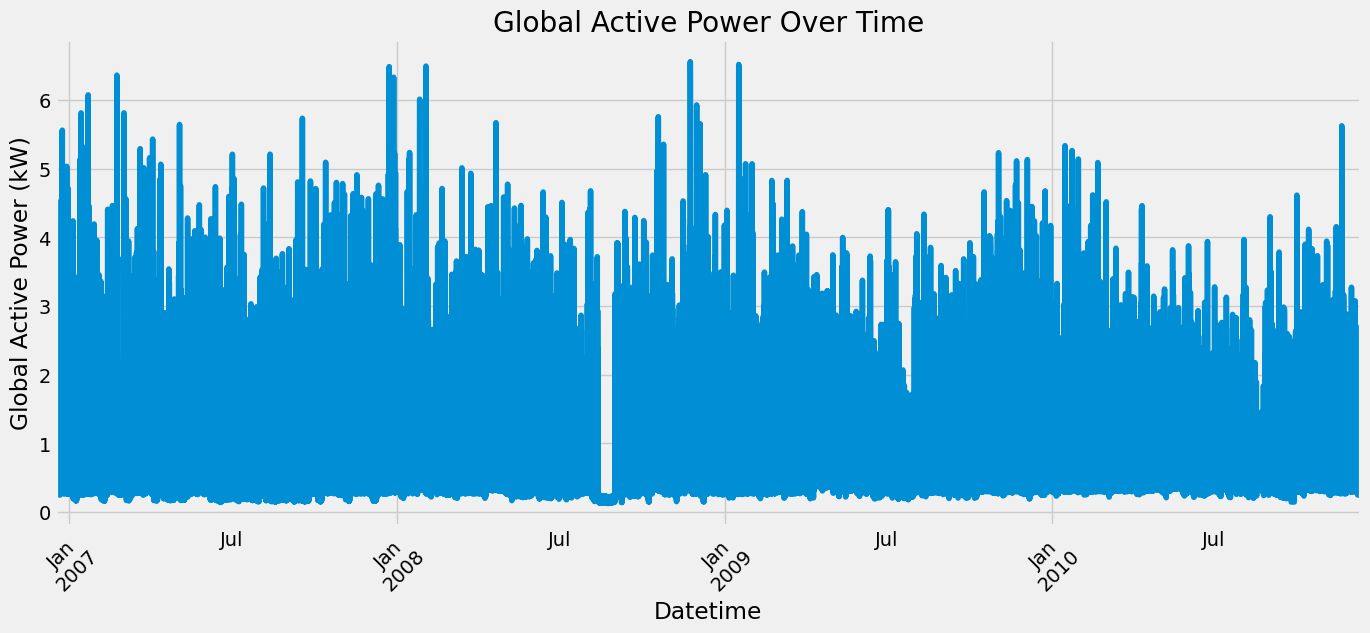

In [293]:
hourly_df['Global_active_power'].plot(figsize=(15, 6))
plt.title('Global Active Power Over Time')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kW)')
plt.xticks(rotation=45) 

In [295]:
hourly_df.reset_index(inplace=True)

hourly_df.head()

,Datetime,Global_active_power
0,2006-12-16 17:00:00,4.222889
1,2006-12-16 18:00:00,3.632200
2,2006-12-16 19:00:00,3.400233
3,2006-12-16 20:00:00,3.268567
4,2006-12-16 21:00:00,3.056467


In [296]:
hourly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34951 entries, 0 to 34950
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Datetime             34951 non-null  datetime64[ns]
 1   Global_active_power  34951 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 546.2 KB


In [403]:
hourly_df_simplified = hourly_df[['Global_active_power']].copy()

In [404]:
hourly_df_simplified.head()

,Global_active_power
0,4.222889
1,3.632200
2,3.400233
3,3.268567
4,3.056467


In [405]:
hourly_df_simplified.isnull().sum()

Global_active_power    0
dtype: int64

In [406]:
type(hourly_df_simplified)

pandas.core.frame.DataFrame

In [407]:
hourly_array = hourly_df_simplified.values
hourly_array

array([[4.22288889],
       [3.6322    ],
       [3.40023333],
       ...,
       [1.1149    ],
       [0.32053333],
       [0.63986667]])

In [408]:
type(hourly_array)

numpy.ndarray

In [409]:
hourly_data_len = math.ceil(len(hourly_array) * .8)

In [410]:
hourly_data_len

27961

In [411]:
scaler = MinMaxScaler(feature_range=(0,1))
hourly_array = scaler.fit_transform(hourly_array)

In [412]:
hourly_array

array([[0.63681623],
       [0.54504495],
       [0.50900588],
       ...,
       [0.15394933],
       [0.03053403],
       [0.08014666]])

In [413]:
train_data = hourly_array[0:training_data_len , :]

In [414]:
x_train =[]
y_train =[]

I will be taking a series of 24 data points (the last 24 hours, in this case) and use that sequence to predict the next data point. 

In [415]:
for i in range(24, len(train_data)):
    x_train.append(train_data[i-24:i,0])
    y_train.append(train_data[i,0])

Make sure that I work with arrays 

In [416]:
x_train, y_train = np.array(x_train), np.array(y_train)

The input value should  be in 3 dimensions - NN input values should be in 3dimensional format

In [417]:
x_train =np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))
x_train.shape

(34927, 24, 1)

In [344]:
model = Sequential()
model.add(LSTM(20, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(20, return_sequences = False))
model.add(Dense(5))
model.add(Dense(1))

In [345]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [346]:
model.fit(x_train, y_train, batch_size = 70, epochs = 10)

Train on 34927 samples
Epoch 1/10
34927/34927 [==============================] - 6s 171us/sample - loss: 0.0134 - acc: 2.8631e-05
Epoch 2/10
34927/34927 [==============================] - 9s 254us/sample - loss: 0.0094 - acc: 2.8631e-05
Epoch 3/10
34927/34927 [==============================] - 8s 236us/sample - loss: 0.0091 - acc: 5.7262e-05
Epoch 4/10
34927/34927 [==============================] - 9s 268us/sample - loss: 0.0089 - acc: 2.8631e-05
Epoch 5/10
34927/34927 [==============================] - 9s 245us/sample - loss: 0.0088 - acc: 5.7262e-05
Epoch 6/10
34927/34927 [==============================] - 11s 311us/sample - loss: 0.0087 - acc: 2.8631e-05
Epoch 7/10
34927/34927 [==============================] - 8s 243us/sample - loss: 0.0086 - acc: 2.8631e-05
Epoch 8/10
34927/34927 [==============================] - 9s 264us/sample - loss: 0.0086 - acc: 5.7262e-05
Epoch 9/10
34927/34927 [==============================] - 9s 260us/sample - loss: 0.0085 - acc: 2.8631e-05
Epoch 10/10
3

In [375]:
test_data = hourly_array[hourly_data_len -24: , :]

In [376]:
x_test = []
y_test = hourly_array[hourly_data_len:, :]

In [377]:
for i in range(24,len(test_data)):
    x_test.append(test_data[i-24:i, 0])

In [378]:
x_test = np.array(x_test)
x_test

array([[0.08412914, 0.12144736, 0.38717011, ..., 0.04562497, 0.03392095,
        0.03469777],
       [0.12144736, 0.38717011, 0.23659216, ..., 0.03392095, 0.03469777,
        0.15177425],
       [0.38717011, 0.23659216, 0.05140966, ..., 0.03469777, 0.15177425,
        0.39878092],
       ...,
       [0.18403799, 0.18104466, 0.08835502, ..., 0.33509757, 0.35235841,
        0.25313834],
       [0.18104466, 0.08835502, 0.11760989, ..., 0.35235841, 0.25313834,
        0.15394933],
       [0.08835502, 0.11760989, 0.02225836, ..., 0.25313834, 0.15394933,
        0.03053403]])

In [379]:
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))

In [383]:
predictions = model.predict(x_test)

In [384]:
predictions = scaler.inverse_transform(predictions)

In [385]:
rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test),predictions))
r2_value = r2_score(scaler.inverse_transform(y_test),predictions)

In [386]:
print("Root Mean Square Error: ", rmse)
print("R^2 Value: ", r2_value)

Root Mean Square Error:  0.5114672258456638
R^2 Value:  0.5124080692996772


In [431]:
train = hourly_df[:hourly_data_len]
valid = hourly_df[hourly_data_len:]
valid['Predictions'] = predictions

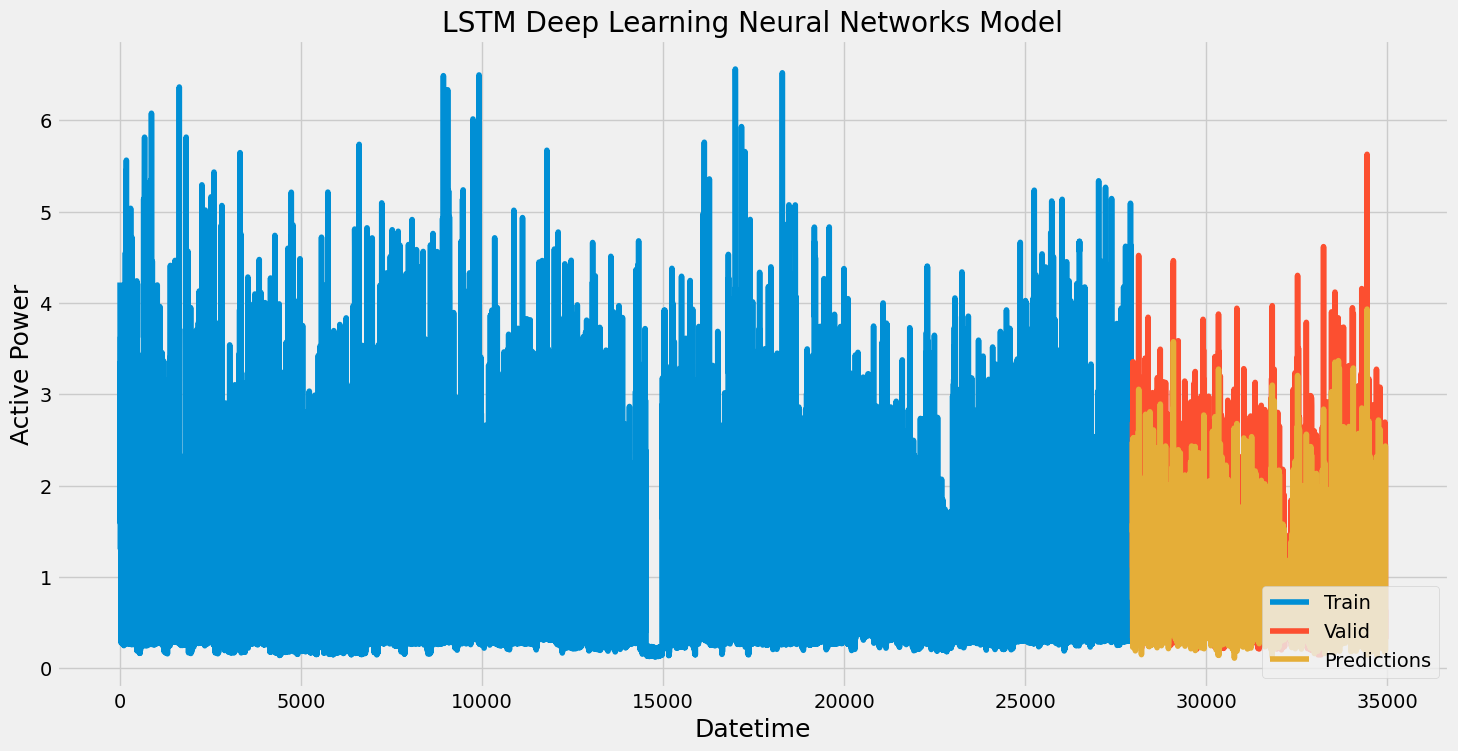

In [429]:
plt.figure(figsize=(16,8))
plt.title('LSTM Deep Learning Neural Networks Model')
plt.xlabel('Datetime',fontsize=18)
plt.ylabel('Active Power', fontsize=18)
plt.plot(train['Global_active_power'])
plt.plot(valid[['Global_active_power', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc = 'lower right')
plt.show()

In [340]:
model = Sequential()
model.add(LSTM(10, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(10, return_sequences = False))
model.add(Dense(5))
model.add(Dense(1))

In [341]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [342]:
model.fit(x_train, y_train, batch_size = 70, epochs = 10)

Train on 34927 samples
Epoch 1/10
34927/34927 [==============================] - 8s 221us/sample - loss: 0.0137 - acc: 2.8631e-05
Epoch 2/10
34927/34927 [==============================] - 8s 237us/sample - loss: 0.0095 - acc: 2.8631e-05
Epoch 3/10
34927/34927 [==============================] - 7s 207us/sample - loss: 0.0093 - acc: 2.8631e-05
Epoch 4/10
34927/34927 [==============================] - 8s 234us/sample - loss: 0.0091 - acc: 2.8631e-05
Epoch 5/10
34927/34927 [==============================] - 8s 217us/sample - loss: 0.0088 - acc: 5.7262e-05
Epoch 6/10
34927/34927 [==============================] - 8s 241us/sample - loss: 0.0086 - acc: 2.8631e-05
Epoch 7/10
34927/34927 [==============================] - 8s 228us/sample - loss: 0.0086 - acc: 5.7262e-05
Epoch 8/10
34927/34927 [==============================] - 9s 254us/sample - loss: 0.0085 - acc: 5.7262e-05
Epoch 9/10
34927/34927 [==============================] - 9s 244us/sample - loss: 0.0085 - acc: 2.8631e-05
Epoch 10/10
34

## Simple model

Using a single LSTM layer

In [421]:
model = Sequential()
model.add(LSTM(units=50, input_shape=(x_train.shape[1], 1)))  # 'units' can be smaller too
model.add(Dense(1))  # One output neuron for regression

In [422]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [423]:
model.fit(x_train, y_train, batch_size = 70, epochs = 10)

Train on 34927 samples
Epoch 1/10
34927/34927 [==============================] - 8s 228us/sample - loss: 0.0119 - acc: 2.8631e-05
Epoch 2/10
34927/34927 [==============================] - 6s 161us/sample - loss: 0.0093 - acc: 2.8631e-05
Epoch 3/10
34927/34927 [==============================] - 6s 181us/sample - loss: 0.0091 - acc: 2.8631e-05
Epoch 4/10
34927/34927 [==============================] - 7s 203us/sample - loss: 0.0087 - acc: 2.8631e-05
Epoch 5/10
34927/34927 [==============================] - 5s 149us/sample - loss: 0.0086 - acc: 5.7262e-05
Epoch 6/10
34927/34927 [==============================] - 9s 260us/sample - loss: 0.0085 - acc: 2.8631e-05
Epoch 7/10
34927/34927 [==============================] - 6s 184us/sample - loss: 0.0085 - acc: 5.7262e-05
Epoch 8/10
34927/34927 [==============================] - 9s 270us/sample - loss: 0.0085 - acc: 5.7262e-05
Epoch 9/10
34927/34927 [==============================] - 7s 203us/sample - loss: 0.0084 - acc: 5.7262e-05
Epoch 10/10
34

## From here is the minute breakdown

As focus will be only on forecasting the overall energy consumption, I will simplify the dataframe and will use only the relevant columns.

In [71]:
# Assuming 'consumption_df' is your original DataFrame with datetime as the index
# And you want to keep only the 'Global_active_power' column along with the datetime index

consumption_df_simplified = df_simplified[['Global_active_power']].copy()

# 'new_df' now contains only the 'Global_active_power' column with the datetime index preserved


In [72]:
consumption_df_simplified.head()

,Global_active_power
0,4.216
1,5.360
2,5.374
3,5.388
4,3.666


Checking the type of the data as for the analyses I will need the data to be an array. 

In [73]:
type(consumption_df_simplified)

pandas.core.frame.DataFrame

Converting to array

In [77]:
dataset_array = consumption_df_simplified.values

In [78]:
type(dataset_array)

numpy.ndarray

As data is sequential we can not use the train test split as it will split it randomly. I will take the first 80% of the data - in order to do that I will use the len function.

In [82]:
training_data_len = math.ceil(len(dataset_array) * .8)

In [83]:
training_data_len 

1660208

Scaling the data using the minmaxscaler. Neural Networks require the data to be in the same range as they are very sensitive, hence scaling is required.

In [86]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset_array = scaler.fit_transform(dataset_array)

In [87]:
dataset_array

array([[0.37479631],
       [0.47836321],
       [0.47963064],
       ...,
       [0.0780373 ],
       [0.07767518],
       [0.07749412]])

In [88]:
train_data = dataset_array[0:training_data_len , :]

In [89]:
x_train =[]
y_train =[]

In [90]:
for i in range(30, len(train_data)):
    x_train.append(train_data[i-30:i,0])
    y_train.append(train_data[i,0])

In [91]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [92]:
x_train =np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))
x_train.shape

(1660178, 30, 1)

In [99]:
model = Sequential()
model.add(LSTM(10, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(10, return_sequences = False))
model.add(Dense(5))
model.add(Dense(1))

In [102]:
#model.compile(optimizer='adam', loss = 'mean_squared_error')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [105]:
model.fit(x_train, y_train, batch_size = 3000, epochs = 10)

Train on 1660178 samples
Epoch 1/10
1660178/1660178 [==============================] - 48s 29us/sample - loss: 0.2627 - acc: 6.0235e-06
Epoch 2/10
1660178/1660178 [==============================] - 50s 30us/sample - loss: 0.2630 - acc: 6.0235e-06
Epoch 3/10
1660178/1660178 [==============================] - 49s 29us/sample - loss: 0.2627 - acc: 6.0235e-06
Epoch 4/10
1660178/1660178 [==============================] - 48s 29us/sample - loss: 0.2627 - acc: 6.0235e-06
Epoch 5/10
1660178/1660178 [==============================] - 48s 29us/sample - loss: 0.2627 - acc: 6.0235e-06
Epoch 6/10
1660178/1660178 [==============================] - 49s 29us/sample - loss: 0.2627 - acc: 6.0235e-06
Epoch 7/10
1660178/1660178 [==============================] - 3664s 2ms/sample - loss: 0.2627 - acc: 6.0235e-06
Epoch 8/10
1660178/1660178 [==============================] - 42s 25us/sample - loss: 0.2628 - acc: 6.0235e-06
Epoch 9/10
1660178/1660178 [==============================] - 1841s 1ms/sample - loss:

In [48]:
consumption_df_simplified = consumption_df[['Datetime', 'Global_active_power']].copy()

# Set 'Datetime' as the index
# consumption_df_simplified.set_index('Datetime', inplace=True)

# Handle missing values. Here, we'll use forward fill as an example
consumption_df_simplified['Global_active_power'].fillna(method='ffill', inplace=True)

# Check the DataFrame
consumption_df_simplified.head()

KeyError: "['Datetime'] not in index"

<function matplotlib.pyplot.show(close=None, block=None)>

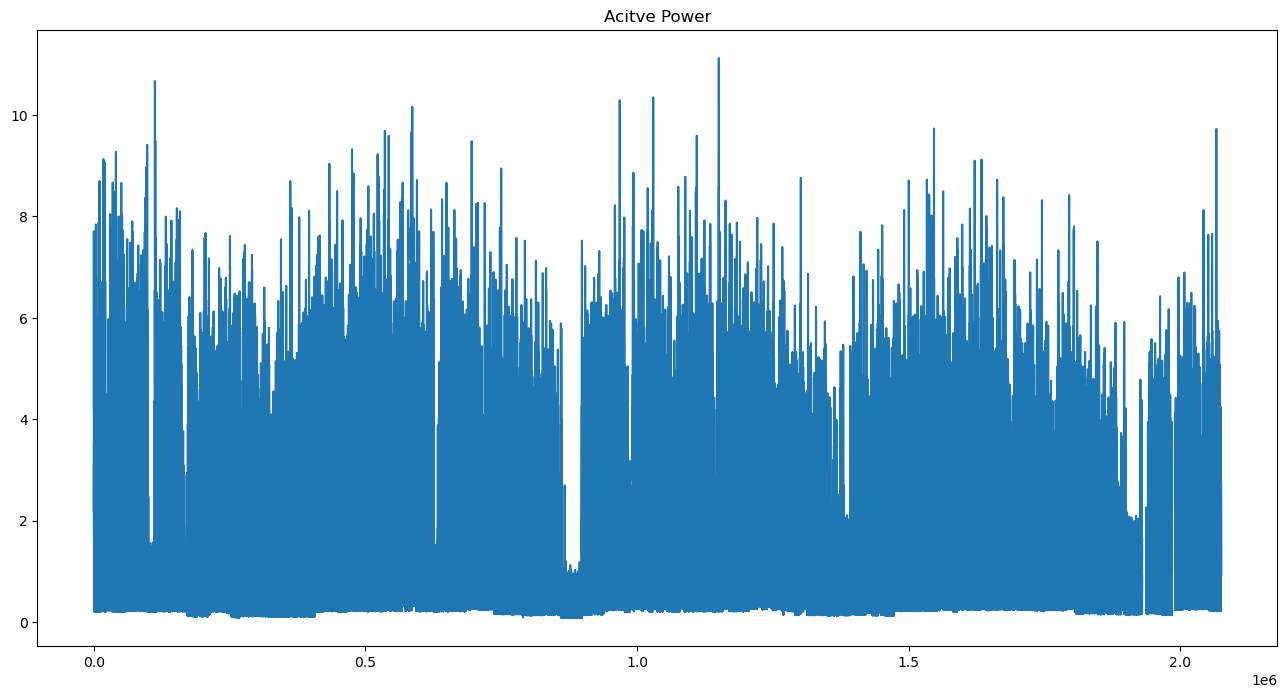

In [9]:
plt.figure(figsize=(16,8))
plt.title('Acitve Power')
plt.plot(consumption_df['Global_active_power'])
plt.show